# Geopandas

This week we'll be looking at the San Andreas Fault that runs along the coast of California using Geopandas. I'm from an area very close to the faultline, and I'd like to figure out how many people live within a mile of the faultline. This type of calculation is very policy-relevant for those working in FEMA, for example. To accomplish this, we'll use data from the census in CA and the USGS. 

This was almost entirely lifted from [here](https://cbrownley.wordpress.com/tag/geopandas/), since Geopandas isn't really my specialty within Python. 

In [20]:
from geopandas import read_file
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

fault_shape_path = Path.cwd() / 'data' / 'Qfaults_GIS' / 'SHP' / 'Qfaults_US_Database.shp'
tract_shp_path   = Path.cwd() / 'data' / 'ca_tracts' / 'cb_2016_06_tract_500k.shp'
tract_json_path  = Path.cwd() / 'data' / 'ca_tracts' / 'tract_pop.json'

## Reading in .shp files

In [5]:
fault_data = read_file(fault_shape_path.as_posix())
fault_data.shape

(112809, 23)

In [6]:
type(fault_data)

geopandas.geodataframe.GeoDataFrame

In [7]:
sa = fault_data[fault_data['fault_name'].str.contains('San Andreas')]
sa = sa[['fault_name', 'age', 'class', 'certainty', 'fault_leng', 'earthquake', 'geometry']]
sa.head()

,fault_name,age,class,certainty,fault_leng,earthquake,geometry
8,San Andreas fault zone,historic,A,Good,1082,San Francisco earthquake,"LINESTRING (-124.07161 40.06145, -124.08192 40..."
9,San Andreas fault zone,historic,A,Good,1082,San Francisco earthquake,"LINESTRING (-124.07800 40.04641, -124.07949 40..."
10,San Andreas fault zone,historic,A,Good,1082,San Francisco earthquake,"LINESTRING (-124.07643 40.04447, -124.07463 40..."
11,San Andreas fault zone,historic,A,Good,1082,San Francisco earthquake,"LINESTRING (-124.07384 40.04120, -124.07281 40..."
12,San Andreas fault zone,historic,A,Good,1082,San Francisco earthquake,"LINESTRING (-124.07747 40.04578, -124.07787 40..."


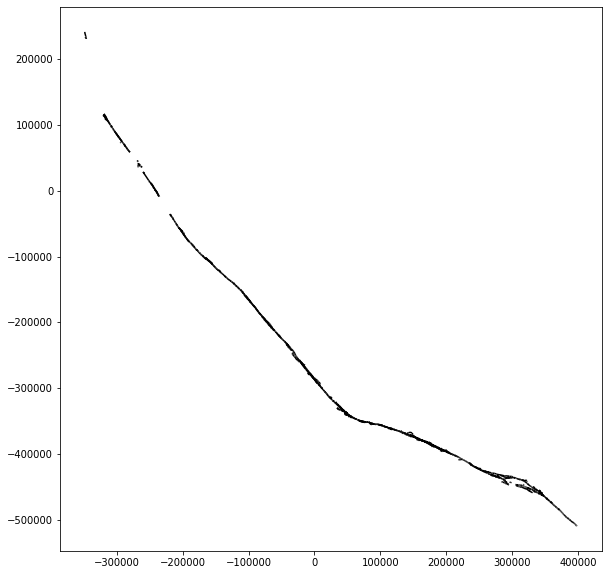

In [8]:
sa = sa.to_crs('epsg:3310')


sa.plot(figsize=(10,10), edgecolor='black', facecolor='white');

In [9]:
def create_buffer(geo, n_meters):
    segments_w_buffers = geo.buffer(n_meters)
    multi_polygon = segments_w_buffers.unary_union
    return multi_polygon

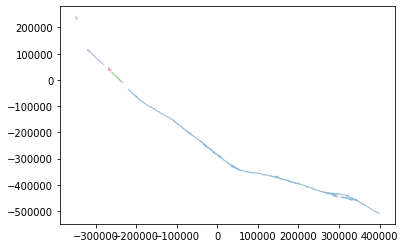

In [14]:
one_mile = create_buffer(sa, 1609.34)
fig, ax = plt.subplots()
for geom in one_mile.geoms:
    xs, ys = geom.exterior.xy
    ax.fill(xs, ys, alpha=0.5)
plt.show()

## California Census Tracts .shp file

In [19]:
ca_tracts = read_file(tract_shp_path.as_posix())
ca_tracts = ca_tracts.rename(columns = {'STATEFP': 'State ID', 'COUNTYFP': 'County ID',
                                        'TRACTCE': 'Tract ID', 'AFFGEOID': 'Aff Geo ID',
                                        'GEOID': 'Geo ID', 'NAME': 'Tract Name',
                                        'LSAD': 'lsad', 'ALAND': 'Land Area',
                                        'AWATER': 'Water Area'})
ca_tracts['County ID'] = ca_tracts['County ID'].astype(int)
ca_tracts['Tract ID']  = ca_tracts['Tract ID'].astype(int)
ca_tracts = ca_tracts.to_crs('epsg:3310')

## California Census Tract Population data

In [45]:
ca_tract_pop = pd.read_json(tract_json_path.as_posix())
ca_tract_pop = ca_tract_pop.iloc[1:,[0,2,3]]
ca_tract_pop.columns = ['Population 2016', 'County ID', 'Tract ID']
ca_tract_pop['Population 2016'] = ca_tract_pop['Population 2016'].astype(float)
ca_tract_pop['County ID'] = ca_tract_pop['County ID'].astype(int)
ca_tract_pop['Tract ID'] = ca_tract_pop['Tract ID'].astype(int)

## Merging Census Tract Data

In [46]:
ca_tracts_merged = ca_tracts.merge(ca_tract_pop, on='Tract ID')

In [47]:
ca_tracts_merged.shape

(16286, 12)

## Manipulating Merged Data

In [58]:
#overlap_mps = [quarter_mile, half_mile, three_quarter_mile, one_mile]
# overlap_mps_str = ['quarter_mile', 'half_mile', 'three_quarter_mile', 'one_mile']
overlap = ca_tracts_merged['geometry'].intersection(one_mile)
ca_tracts_merged['One Mile'] = overlap
merged = ca_tracts_merged
merged['Tract Area']      = merged.geometry.area
merged['Buffer Area']     = [geo.area for geo in merged['One Mile']]
merged['Percent Overlap'] = merged['Buffer Area'] / merged['Tract Area']
merged['Affected Pop']    = [round(val) for val in merged['Percent Overlap'] * merged['Population 2016']]

merged = merged.sort_values(by='Affected Pop', ascending=False)
merged['Affected Pop'][:10]

12002    8704
10176    8671
10178    8570
10175    8240
10079    8023
12003    7951
10174    7835
16075    7022
7651     6926
14005    6801
Name: Affected Pop, dtype: int64

In [59]:
print(merged['Affected Pop'].sum())

598037
